In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns             
import datetime
pd.set_option('display.max_rows', 500)
%matplotlib inline

In [2]:
# Source: http://web.mta.info/developers/turnstile.html
def get_data(week_nums):
    dfs = []
    for week_num in week_nums:
        file="/Users/poonamgaikar/metis/turnstile_"+str(week_num)+".txt"
        dfs.append(pd.read_csv(file))
    return pd.concat(dfs)
        
week_nums = [190518,190525,190601,190608,190615,190622,190629,190706,190713,190720,190727,190803]
df = get_data(week_nums)

In [3]:
# Data cleaning

In [4]:
df.columns = df.columns.str.replace(' ', '') #removed spaces rename column

In [5]:
station_mask = (
                (df["STATION"] == "ATLANTIC AV") |
                (df["STATION"] == "FLATBUSH AV-B.C")|
                (df["STATION"] == "ATL AV-BARCLAY")|
                (df["STATION"] == "25 AV")|
                (df["STATION"] == "BERGEN ST")|
                (df["STATION"] == "FULTON ST")|
                (df["STATION"] == "LAFAYETTE AV")
               )
station_mask

0         False
1         False
2         False
3         False
4         False
          ...  
206991    False
206992    False
206993    False
206994    False
206995    False
Name: STATION, Length: 2480091, dtype: bool

In [6]:
ss=df[station_mask]

In [7]:
ss=ss.drop(columns=['LINENAME','DIVISION','DESC']) #droped unwated columns

In [8]:
ss["TURNSTILE"]=ss[ "C/A"]+ss["UNIT"]+ss["SCP"]+ss["STATION"]

In [9]:
ss[(ss["TURNSTILE"] =="N098R02800-02-01FULTON ST") &
    ((ss["DATE"] == "07/28/2021") |
     (ss["DATE"] == "07/27/2021"))]

,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS,TURNSTILE


In [10]:
ss = (ss.groupby(
    ["TURNSTILE","DATE","STATION"],
    as_index=False).ENTRIES.first())

In [11]:
ss[["PREV_DATE", "PREV_ENTRIES"]] = (ss.groupby(["TURNSTILE"])["DATE", "ENTRIES"].apply(lambda grp: grp.shift(1)))

/var/folders/w6/39bqqg4n2fgfbdxwjd1r1_rw0000gs/T/ipykernel_56947/2752554790.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ss[["PREV_DATE", "PREV_ENTRIES"]] = (ss.groupby(["TURNSTILE"])["DATE", "ENTRIES"].apply(lambda grp: grp.shift(1)))


In [12]:
ss[(ss["TURNSTILE"] =="N098R02800-02-01FULTON ST") &
    ((ss["DATE"] == "07/28/2021") |
     (ss["DATE"] == "07/27/2021"))]

,TURNSTILE,DATE,STATION,ENTRIES,PREV_DATE,PREV_ENTRIES


In [13]:
# Drop the rows for the earliest date in the df
ss.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [14]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        return 0
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits


In [15]:
ss["DAILY_ENTRIES"]= ss.apply(get_daily_counts, axis=1, max_counter=100000)

2254 238251.0
569320813 4807409.0
14 1327005.0
2162762 33622258.0


In [31]:
ss.head(10)

,TURNSTILE,DATE,STATION,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES,DATE_TIME,WEEK,DAY
2,A077R02803-00-00FULTON ST,05/13/2019,FULTON ST,61510,05/12/2019,61303.0,207.0,2019-05-13,20,0
3,A077R02803-00-00FULTON ST,05/14/2019,FULTON ST,62463,05/13/2019,61510.0,953.0,2019-05-14,20,1
4,A077R02803-00-00FULTON ST,05/15/2019,FULTON ST,63582,05/14/2019,62463.0,1119.0,2019-05-15,20,2
5,A077R02803-00-00FULTON ST,05/16/2019,FULTON ST,64790,05/15/2019,63582.0,1208.0,2019-05-16,20,3
6,A077R02803-00-00FULTON ST,05/17/2019,FULTON ST,66066,05/16/2019,64790.0,1276.0,2019-05-17,20,4
9,A077R02803-00-00FULTON ST,05/20/2019,FULTON ST,68011,05/19/2019,67675.0,336.0,2019-05-20,21,0
10,A077R02803-00-00FULTON ST,05/21/2019,FULTON ST,69134,05/20/2019,68011.0,1123.0,2019-05-21,21,1
11,A077R02803-00-00FULTON ST,05/22/2019,FULTON ST,70321,05/21/2019,69134.0,1187.0,2019-05-22,21,2
12,A077R02803-00-00FULTON ST,05/23/2019,FULTON ST,71505,05/22/2019,70321.0,1184.0,2019-05-23,21,3
13,A077R02803-00-00FULTON ST,05/24/2019,FULTON ST,72679,05/23/2019,71505.0,1174.0,2019-05-24,21,4


In [16]:
ss["DATE_TIME"]=pd.to_datetime(ss["DATE"])

In [17]:
ss["WEEK"]=ss["DATE_TIME"].dt.isocalendar().week

In [18]:
ss["DAY"]=ss["DATE_TIME"].dt.dayofweek

In [19]:
MASK=((ss["DAY"] == 0) |
      (ss["DAY"] == 1) |
      (ss["DAY"] == 2) |
      (ss["DAY"] == 3) |
      (ss["DAY"] == 4) 
     )
      

In [20]:
ss=ss[MASK]

In [21]:
t=ss[( (ss["WEEK"]==30) &
     (ss["STATION"] == "FULTON ST" )  
   )]

In [22]:
t.sort_values(by="DAILY_ENTRIES", ascending=False)

,TURNSTILE,DATE,STATION,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES,DATE_TIME,WEEK,DAY
4105,N095R01400-03-04FULTON ST,07/25/2019,FULTON ST,110983,07/24/2019,1.075870e+05,3396.0,2019-07-25,30,3
4106,N095R01400-03-04FULTON ST,07/26/2019,FULTON ST,114344,07/25/2019,1.109830e+05,3361.0,2019-07-26,30,4
3853,N095R01400-03-01FULTON ST,07/25/2019,FULTON ST,6961610,07/24/2019,6.958276e+06,3334.0,2019-07-25,30,3
3938,N095R01400-03-02FULTON ST,07/26/2019,FULTON ST,5646072,07/25/2019,5.642749e+06,3323.0,2019-07-26,30,4
4190,N095R01400-03-05FULTON ST,07/26/2019,FULTON ST,4517612,07/25/2019,4.514314e+06,3298.0,2019-07-26,30,4
4022,N095R01400-03-03FULTON ST,07/26/2019,FULTON ST,5021531,07/25/2019,5.018296e+06,3235.0,2019-07-26,30,4
3937,N095R01400-03-02FULTON ST,07/25/2019,FULTON ST,5642749,07/24/2019,5.639533e+06,3216.0,2019-07-25,30,3
3854,N095R01400-03-01FULTON ST,07/26/2019,FULTON ST,6964809,07/25/2019,6.961610e+06,3199.0,2019-07-26,30,4
3852,N095R01400-03-01FULTON ST,07/24/2019,FULTON ST,6958276,07/23/2019,6.955085e+06,3191.0,2019-07-24,30,2
4021,N095R01400-03-03FULTON ST,07/25/2019,FULTON ST,5018296,07/24/2019,5.015105e+06,3191.0,2019-07-25,30,3


In [23]:
VOLUME_PER_STATION=ss.groupby(["WEEK","STATION"])["DAILY_ENTRIES"].sum().reset_index()

In [24]:
VOLUME_PER_STATION

,WEEK,STATION,DAILY_ENTRIES
0,20,25 AV,22672.0
1,20,ATL AV-BARCLAY,201027.0
2,20,ATLANTIC AV,7688.0
3,20,BERGEN ST,70823.0
4,20,FLATBUSH AV-B.C,95328.0
5,20,FULTON ST,445416.0
6,20,LAFAYETTE AV,23115.0
7,21,25 AV,23012.0
8,21,ATL AV-BARCLAY,204105.0
9,21,ATLANTIC AV,7757.0


In [25]:
VOLUME_PER_WEEK=ss.groupby(["WEEK"])["DAILY_ENTRIES"].sum().reset_index()

In [26]:
VOLUME_PER_WEEK.head(50)

,WEEK,DAILY_ENTRIES
0,20,866069.0
1,21,871534.0
2,22,758064.0
3,23,864482.0
4,24,861045.0
5,25,865104.0
6,26,857167.0
7,27,729750.0
8,28,824252.0
9,29,818333.0


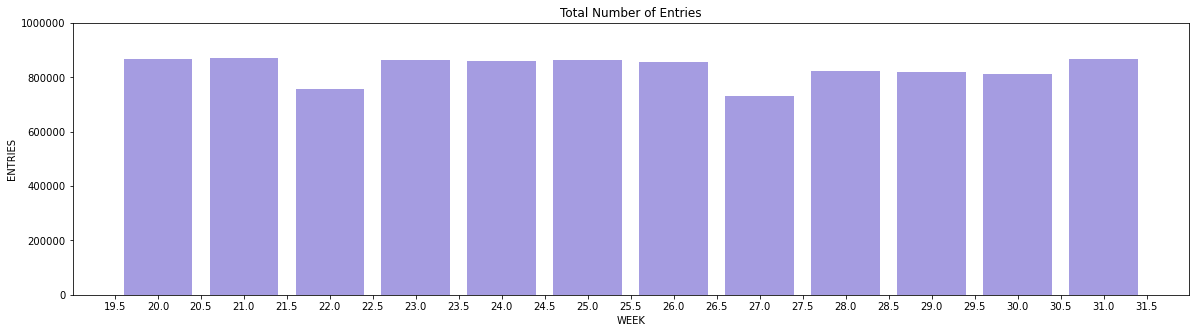

In [30]:
plt.figure(figsize=(20,5))
# plt.fill_between(WEEKLY_ENTRIES['WEEK'], WEEKLY_ENTRIES['ENTRIES'], color='skyblue', alpha=0.5)
plt.bar(VOLUME_PER_WEEK['WEEK'], VOLUME_PER_WEEK['DAILY_ENTRIES'], color="Slateblue", alpha=0.6)
plt.xlabel('WEEK')
plt.ylabel('ENTRIES')
plt.ylim(0,1000000)
plt.title('Total Number of Entries')
plt.locator_params(axis='x', nbins=40)
plt.ticklabel_format(axis="y", style="plain");

In [ ]:
plt.figure(figsize=(10,5))
# plt.fill_between(WEEKLY_ENTRIES['WEEK'], WEEKLY_ENTRIES['ENTRIES'], color='skyblue', alpha=0.5)
plt.plot(VOLUME_PER_STATION['WEEK'], VOLUME_PER_STATION['DAILY_VOLUME'], color="Slateblue", alpha=0.6)
plt.xlabel('WEEK')
plt.ylabel('ENTRIES')
plt.ylim(0,1600000)
plt.title('Total Number of Entries')
plt.locator_params(axis='x', nbins=26)
plt.ticklabel_format(axis="y", style="plain");

In [ ]:
plt.figure(figsize=(14, 8))
plt.title("Total Traffic For Stations Near Barclays center")
graph1DF = VOLUME_PER_STATION.groupby(['STATION']).DAILY_ENTRIES.agg(['sum']).reset_index()
graph1DF = graph1DF.nlargest(10,'sum')
sns.barplot(x="DAILY_ENTRIES", y="STATION", orient = "h", data=VOLUME_PER_STATION, palette = "Blues_d")
plt.savefig('Stations near Barclays.png', dpi = 1000)